In [7]:
import os
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from comet_ml import Experiment
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

X_train shape:  (7427,)
X_test shape:  (2226,)


/Users/henrystoll/SDK/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_box" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


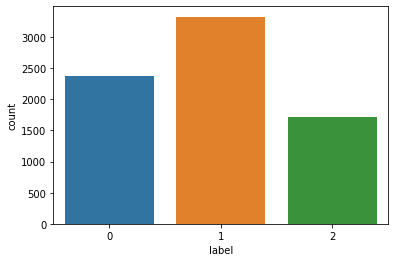

In [8]:
train_df = pd.read_csv('../data/tweets_50_shuffled_train.csv')
test_df = pd.read_csv('../data/tweets_50_shuffled_test.csv')
X_train = train_df['text_tokenized']
y_train = train_df['label']
X_test = test_df['text_tokenized']
y_test = test_df['label']

class_names = y_train.unique()
# print("Class names: ", class_names)
print("X_train shape: ", X_train.shape)
# print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
# TODO: save
sns.countplot(x=y_train)
plt.savefig('../img/class_imbalance.png',bb_box='tight')

In [9]:
batch_size = 128
max_tokens = 20_000
output_sequence_length=4000
embedding_dim = 300


def make_vectorizer(max_tokens: int, output_sequence_length: int) -> TextVectorization:
    vect = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
    text_ds = tf.data.Dataset.from_tensor_slices(X_train.values).batch(batch_size)
    vect.adapt(text_ds)
    return vect


def get_embedding_matrix(embedding_dim, num_tokens, word_index):
    path_to_glove_file = f"glove.6B.{embedding_dim}d.txt"
    
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print("Found {} word vectors.".format(len(embeddings_index)))
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def make_embedding_layer(voc: List[str], embedding_dim: int) -> layers.Embedding:
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2

    # just testing if word_index works
    test = ["the", "cat", "sat", "on", "the", "mat"]
    print("word_index test:")
    print(test, " --> ", [word_index[w] for w in test])

    embedding_matrix = get_embedding_matrix(embedding_dim, num_tokens, word_index)

    return layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=True,
        mask_zero=True
    )


vectorizer = make_vectorizer(max_tokens=max_tokens,
                             output_sequence_length=output_sequence_length)
vocabulary = vectorizer.get_vocabulary()
embedding_layer = make_embedding_layer(vocabulary, embedding_dim=embedding_dim)


KeyboardInterrupt: 

In [ ]:
epochs = 200
optimizer = 'nadam'
activation = 'relu'
kernel_initializer = 'he_normal'
l2_lambda = 1e-3
dropout=0.5
filters = 128
n_convs_depth = 1
# kernel_size = 3
kernel_sizes = [1, 2, 3]
n_convs_parallel = len(kernel_sizes)
padding='same'
pool_size = 3
# pool_size = 5
strides = 1
# strides = 2
class_weight = None
embedding='mask & trainable'

def make_model():
    regularizers = keras.regularizers.l2(l2=l2_lambda)
    convs = []
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    embed = embedding_layer(x)
    for kernel_size in kernel_sizes:
        # for _ in range(n_convs_depth):
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation=activation,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=regularizers,
            padding=padding,
        )(embed)
        x = layers.SpatialDropout1D(dropout)(x)
        x = layers.MaxPooling1D(pool_size=pool_size, strides=strides)(x)
        convs.append(layers.GlobalMaxPooling1D()(x))

    x = layers.Concatenate()(convs)
    x = layers.Dense(n_convs_parallel*filters, activation=activation, kernel_regularizer=regularizers)(x)
    x = layers.Dropout(dropout)(x)
    output_ = layers.Dense(len(class_names), activation="softmax")(x)
    model = keras.Model(string_input, output_)
    model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
    )
    return model

In [ ]:
project_name = 'nlp_split'
experiment = Experiment(
    project_name=project_name,
    auto_param_logging=True,
    # auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
    api_key="HeH9EtfDC2KUlCOjeQaU1CuOM",
    workspace="henrystoll",
)
params = {
    'batch_size': batch_size,
    'max_tokens': max_tokens,
    'output_sequence_length': output_sequence_length,
    'embedding_dim': embedding_dim,
    'embedding': embedding,
    'filters': filters,
    'kernel_sizes': kernel_sizes,
    'pool_size': pool_size,
    'padding': padding,
    'strides': strides,
    'n_convs_depth': n_convs_depth,
    'n_convs_parallel': n_convs_parallel,
    'activation': activation,
    'kernel_initializer': kernel_initializer,
    'l2_lambda': l2_lambda,
    'dropout': dropout,
    'class_weight': class_weight,
    'optimizer': optimizer,
    'epochs': epochs,
}

experiment.log_parameters(params)

model = make_model()
# keras.utils.plot_model(model, "model.png", show_shapes=True)
# experiment.log_asset("model.png")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    verbose=1,
    restore_best_weights=True)

with experiment.train():
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        class_weight=class_weight,
                        verbose=1,
                        callbacks=[early_stopping])

with experiment.test():
    loss, accuracy = model.evaluate(X_test, y_test)
    print('acc : {:.3f}'.format(accuracy))
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    experiment.log_metrics(metrics)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=1)
experiment.log_confusion_matrix(y_test.to_numpy(), y_predicted)

experiment.end()